# Taylor Swift Discography: Part II - Discography Statistics

## Introduction

This notebook is the second in a series of notebooks analyzing Taylor Swift's discography; in this notebook, I query data from the [database made in Part I](./01_data_collection.ipynb) and display them by building charts via matplotlib and seaborn.

All SQL queries made in this notebook are available in the [sql folder](./sql).

This notebook uses the modules [`charts.py`](./src/charts.py) to build charts in seaborn/matplotlib and [`toolkit.py`](./src/toolkit.py) for miscellanious tasks made throughout this notebook.

**Please note this notebook is a work-in-progress and not yet complete.**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3 as sql
from matplotlib import rcParams

from src import charts
from src import toolkit

connection = sql.connect('data/taylor_swift.db')
cursor = connection.cursor()

In [2]:
# Dictionaries to define categorical order and color palettes
eras = {
    'Taylor Swift': '#A5C9A5',
    'Fearless': '#F7ED67',
    'Speak Now': '#DE72EC',
    'Red': '#E0374F',
    '1989': '#8ADBFB',
    'reputation': '#746F70',
    'Lover': '#F7B0CC',
    'folklore': '#CDC9C1',
    'evermore': '#C5AC90',
    'Fearless (TV)': '#EFC180',
    'Red (TV)':  '#7A2E39',
    'Midnights': '#242E47',
    'Speak Now (TV)': '#C7A8CB',
    '1989 (TV)': '#B5E5F8',
    'Non-Album Songs': '#BF360C',
    'Other Artist Songs': '#607D8B'}

credits = {
    'writer': '#6D466B',
    'producer': '#58A4B0',
    'artist': '#FF6B6C'}

In [3]:
# Setting the aesthetic parameters for the charts
toolkit.install_fonts()
rcParams['font.family'] = 'Lato'
rcParams['figure.dpi'] = 150
rcParams['savefig.dpi'] = 150
custom_params = {'ytick.left': True, 
                 'xtick.bottom': True}

In [4]:
# Creating several temporary tables to be used throughout
temp_tables = toolkit.sql_to_string('temp_tables.sql')
cursor.executescript(temp_tables)

## Most Collaborative Eras

Over her career, Taylor Swift has worked with numerous writers, producers, and fellow artists to create her musical catalogue, demonstrated by the musician credits on each song. However, some of her albums and overall musical eras are more collaborative efforts than others; while an album may not have many featured artists, it could still be very collaborative in terms of writing or producing. In order to see which eras had overall more collaborators than others, I use two approaches:

1. I count the number of *unique* writers, producers, and artists per song and summarize by era. I then calculate the means for each musician type across all eras. Finally, I compare the totals per era to the means to determine which eras are the most and least collaborative.
2. I count the *total* number of writers, producers, and artists per song before summarizing by era. I then calculate the average amount of writers, producers, and artists per song for each era, as well as the overall means for each musician type per song. Finally, I compare the eras' averages to the overall means to determine which eras are the most and least collaborative.

### Unique Musicians Per Era

In [5]:
unique_credit_per_era = toolkit.sql_to_string('unique_credit_per_era.sql')

unique_credit = pd.read_sql(unique_credit_per_era, connection)
toolkit.sort_cat_column(unique_credit, 'era', eras.keys())
unique_credit.head(9)

,era,type,unique_count
0,Taylor Swift,writer,7
1,Taylor Swift,producer,5
2,Taylor Swift,artist,1
3,Fearless,writer,8
4,Fearless,artist,2
5,Fearless,producer,2
6,Speak Now,artist,2
7,Speak Now,writer,3
8,Speak Now,producer,3


In [6]:
# Pivoting dataframe for chart table
unique_credit_pivot = unique_credit.pivot(columns='era', index='type', values='unique_count')
unique_credit_pivot.sort_values('type', ascending=False, inplace=True)

# Calculating overall means for type
avg_per_type_unique = unique_credit.groupby('type')['unique_count'].mean().sort_values(ascending=False)
avg_per_type_unique

type
writer      10.375
producer     7.750
artist       3.875
Name: unique_count, dtype: float64

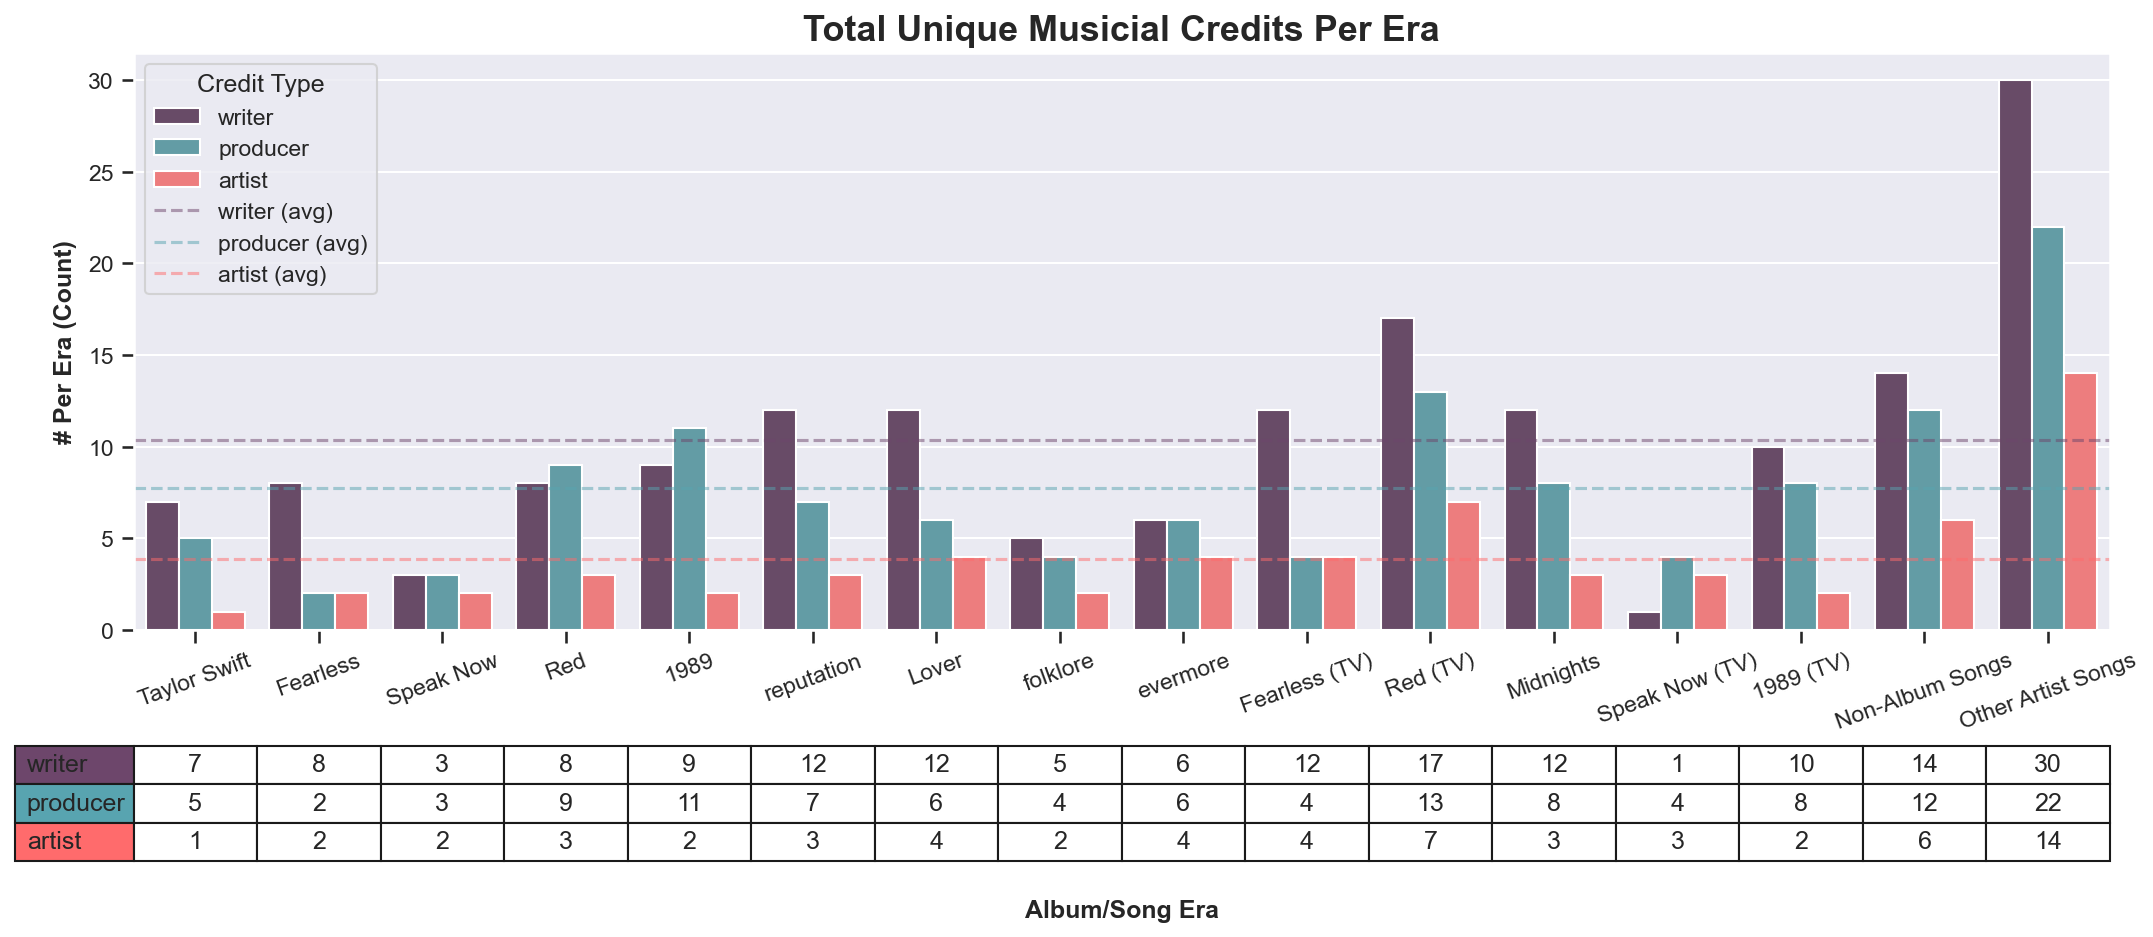

In [7]:
charts.credit_chart(credits, custom_params, 'bar', unique_credit, 'era', 'unique_count', 'type', 
                    avg_per_type_unique, 'Total Unique Musicial Credits Per Era',
                    'Album/Song Era', '# Per Era (Count)', 'Credit Type', True,
                    True, 'unique_credits_per_era.png', True, unique_credit_pivot)

Looking at the bars, we can clearly see which eras had the most unique collaborators. More than any album or rerecording, Taylor works with the more unique musicians when collaborating on other artists' songs, as that era's totals are the highest for all three musician types. In second place is "Red (Taylor's Version)," which has the second highest totals for each musician type. For the lowest totals, "Speak Now (Taylor's Version)" only has 1 unique writer for the era, "Fearless" has only 2 unique producers, and the debut "Taylor Swift" only has 1 unique artist.

To determine her most and least collaborative eras, we'll look at where the totals fall relative the overall means per type (represented by horizontal dash lines). For her most collaborative eras, both her collaborations on other artist's songs and her non-album works fall above the means for all three musician types; "Red (Taylor's Version)" also has totals above all three means, being her only studio album or rerecording to do so. For least collaborative, several eras fall below the overall means for all three types: the self-titled "Taylor Swift," "Fearless," "Speak Now," "folklore," "evermore," and "Speak Now (Taylor's Version)." This makes it difficult to narrow down which albums could be considered the least collaborative.

I also have other issues with determinining collaborativeness through this approach: one issue is that it doesn't take into consideration the lengths of albums and how that can skew the counts of unique musicians. For instance, "Red (Taylor's Version)" has over 30 songs associated with the era, while "folklore" and "evermore" only have 17 each; even if "folklore" and "evermore" featured unique writers, producers, and/or artists for every track, it's still possible for them to fall below "Red (Taylor's Version)" in totals due to having less songs overall. Also, this method doesn't account for variability between individual songs when it comes to writers, producers, or artists. For example, "Midnights" features a track, "Lavender Haze," that has 6 unique writers alone while also featuring a track, "Bigger Than the Whole Sky," that is solely written by Taylor herself. That variation is not accounted for when totaling unique writers between the two tracks, which would still be a total of 6.

Accounting for these issues lead me to my second approach: calculating the average musician type per indiviudal song and comparing the overall averages by era.

### Average Musicians Per Song By Era

In [8]:
avg_credit_per_song = toolkit.sql_to_string('avg_credit_per_song.sql')

avg_credit = pd.read_sql(avg_credit_per_song, connection)
toolkit.sort_cat_column(avg_credit, 'era', eras.keys())
avg_credit.head(9)

,era,type,avg_per_song
0,Taylor Swift,writer,2.07
1,Taylor Swift,producer,1.14
2,Taylor Swift,artist,1.00
3,Fearless,writer,1.67
4,Fearless,artist,1.06
5,Fearless,producer,2.00
6,Speak Now,artist,1.06
7,Speak Now,writer,1.11
8,Speak Now,producer,1.89


In [9]:
# Pivoting dataframe for chart table
avg_credit_pivot = avg_credit.pivot(columns='era', index='type', values='avg_per_song')
avg_credit_pivot.sort_values('type', ascending=False, inplace=True)

# Calculating overall means for type-per-song
avg_per_type = avg_credit.groupby('type')['avg_per_song'].mean().sort_values(ascending=False)
avg_per_type

type
writer      2.088125
producer    1.928750
artist      1.153125
Name: avg_per_song, dtype: float64

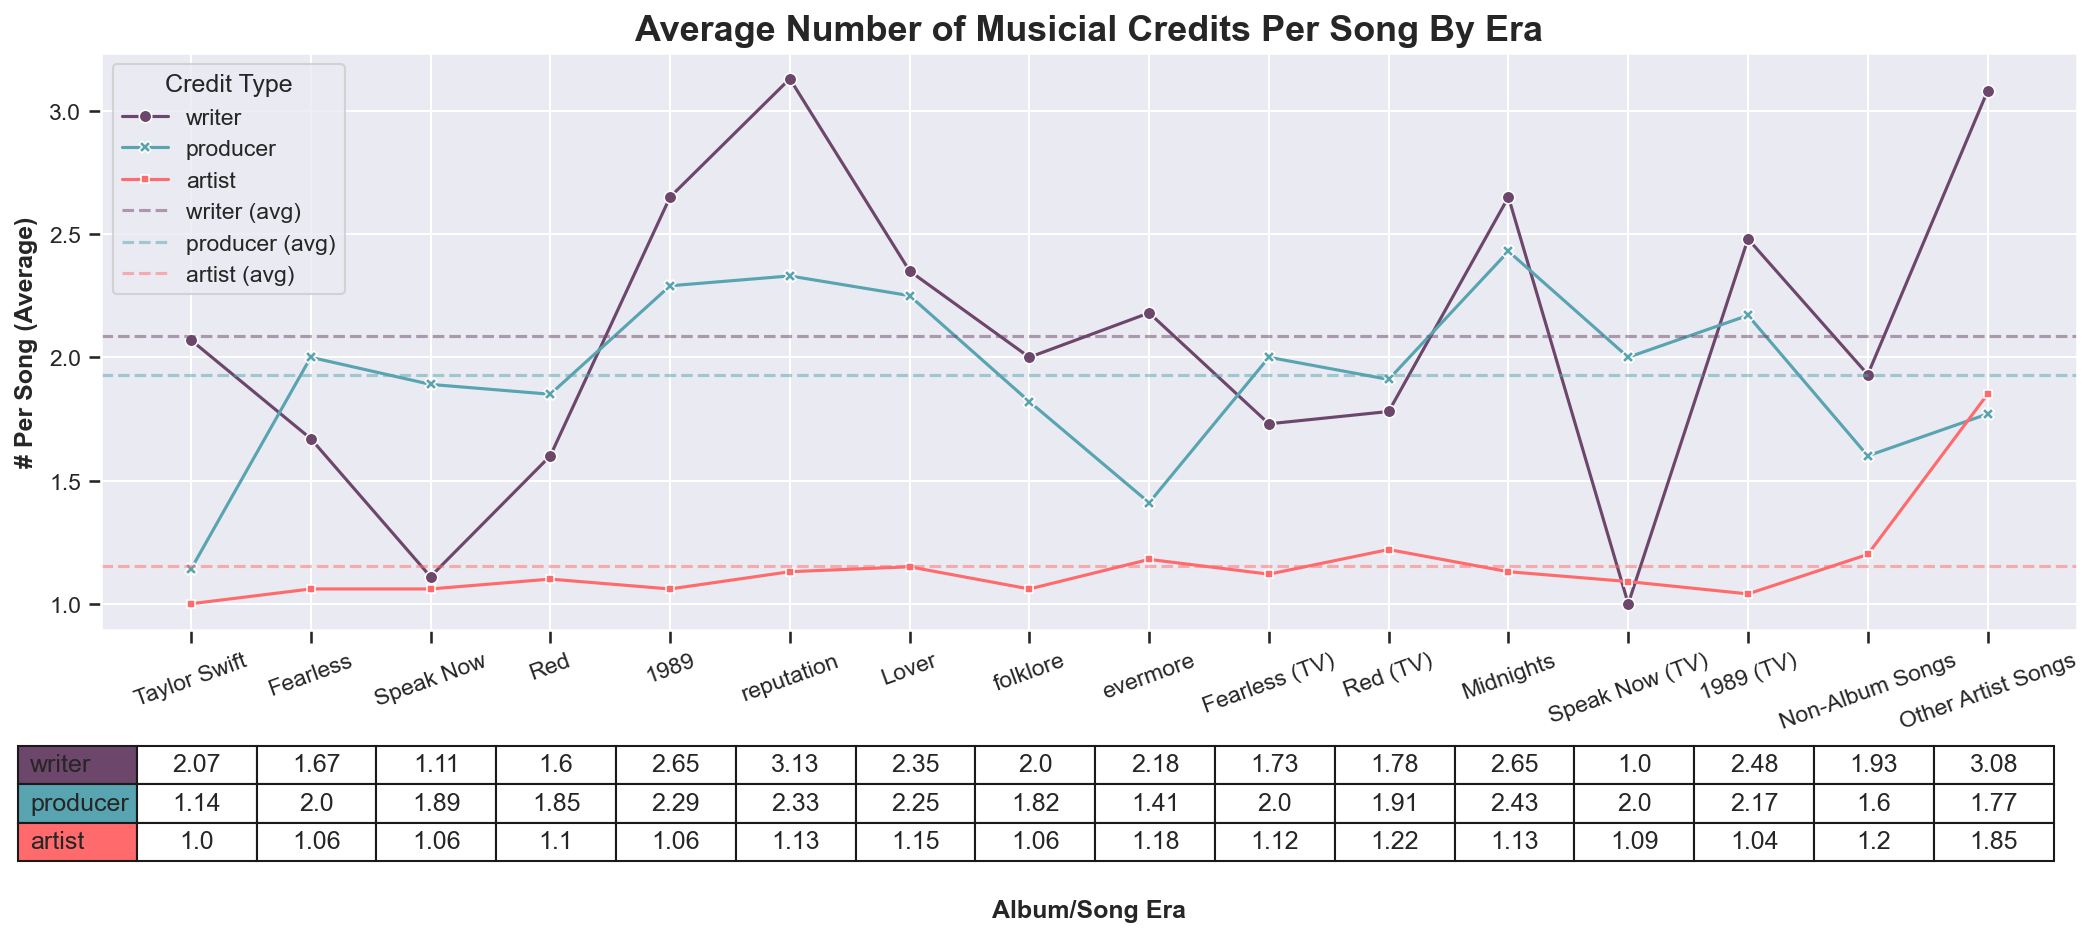

In [10]:
charts.credit_chart(credits, custom_params, 'line', avg_credit, 'era', 'avg_per_song', 'type', 
                    avg_per_type, 'Average Number of Musicial Credits Per Song By Era',
                    'Album/Song Era', '# Per Song (Average)', 'Credit Type', True,
                    True, 'avg_credits_per_song.png', True, avg_credit_pivot)

This analytical approach gives us a more nuanced way to which eras were more collaborative in terms of individual musician types. For instance, both "reputation" and "Midnights" were highly collaborative eras, with the former having the highest average of writers per song (3.13 writers) and the latter having the highest average of producers per song (2.43 producers). Meanwhile, both "Speak Now" and "Speak Now (Taylor's Version)" have the lowest average of 1.11 and 1.0 writers per song respectively, the rerecording being solely written by Taylor herself, and the self-titled "Taylor Swift" has the lowest average of 1.14 producers per song, followed by "evermore" at 1.41 producers. Her collaborations with artists tend to be more steady, many albums having few vocal features, but "Red (Taylor's Version)" boasts the highest average of her studio albums and rerecordings, of 1.22 artists per song. Unsurprisingly, this is surpassed by her collaboration songs on other artists' albums, which have an average artist-per-song of 1.85 and usually feature another artist alongside Taylor Swift.

To determine her most and least collaborative eras, we'll once again look at where the average values fall relative the overall means (represented by horizontal dash lines). Four eras fall below all three means: "Taylor Swift", "Speak Now", "Red", and "folklore." That means that, according to both this approach and the previous approach, "Taylor Swift", "Speak Now," and "folklore" are considered Taylor's least collaborative eras. Interestingly, no era has all values fall above the overall means; "Lover" has higher averages for both writers-per-song and producers-per-song, but its average for artists-per-song is equal to the overall mean for artists-per-song. Regardless, its values being at-or-above each mean makes it the most collaborative era via this approach, despite not being considered especially collaborative via the previous approach.

Whichever method one uses to determine most and least collaborative eras is ultimately up to the individual. While both of these approaches determine collaborativeness in their own ways, I can only conclude which eras are Taylor Swift's least collaborative ("Taylor Swift," "Speak Now," and "folklore") based on the results of these two approaches.

## TBA (Work in Progress)

In [11]:
connection.close()